In [ ]:
import os
import re
import nltk
import spacy
import numpy as np
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler


nltk.download('punkt_tab')
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm")

stop_words = set(stopwords.words('english'))
stop_words = [i for i in stop_words if i not in ['not','until','against','up', 'down', 'no', 'nor',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",
                                                 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "don't"]]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv("/dataset (3).csv")
df=df.sample(frac=1)
df=df.head(10000)
df.head()

,Unnamed: 0,content,label
9397,9397,don't let @tsand know he'll make me give up m...,0
4402,4402,Now I'm gonna have to go back to McLuhan & Lea...,1
1814,1814,I don't know about that... Drew's ass is prett...,1
3515,3515,Hell yeah the drunker the better...is drunker ...,1
9532,9532,I hate to cook and do simple things that somet...,0


**1) DATA CLEANING**

In [ ]:
def get_word_len(content):
  return len(content.split(' '))

def get_char_len(content):
  return len(content);

def preprocess_data(content):
  content=content.lower()
  #Using regex to clean the content
  content=re.sub(r"http\S+|www\S+|https\S+", '', content, flags=re.MULTILINE)  #Remove links
  content=re.sub(r'@\w+', '', content) #Remove any mentions e.g- @username
  content=re.sub(r'[^\w\s#]', '', content)
  #Creating tokens
  tokens=[token.lemma_ for token in nlp(content)]
  tokens=[token for token in tokens if token not in stop_words]
  tokens=[token for token in tokens if len(token)>1]
  processed_cotent=" ".join(tokens)
  return processed_cotent

df["clean_content"]=[preprocess_data(cont) for cont in tqdm(df["content"],position=0,leave=True)]  #tqdm used for show the progress of processing
df["content_word_len"]=df["clean_content"].apply(get_word_len)
df["content_char_len"]=df["clean_content"].apply(get_char_len)

df.head()

100%|██████████| 10000/10000 [01:43<00:00, 96.87it/s]


,Unnamed: 0,content,label,clean_content,content_word_len,content_char_len
9397,9397,don't let @tsand know he'll make me give up m...,0,not let know hell make give up man card remind...,13,63
4402,4402,Now I'm gonna have to go back to McLuhan & Lea...,1,go go back mcluhan leary help translate wtf wr...,13,70
1814,1814,I don't know about that... Drew's ass is prett...,1,not know drews ass pretty tiny knee work e...,17,70
3515,3515,Hell yeah the drunker the better...is drunker ...,1,hell yeah drunker betteris drunker wordmore dr...,13,86
9532,9532,I hate to cook and do simple things that somet...,0,hate cook simple thing sometimes get boring wi...,12,69


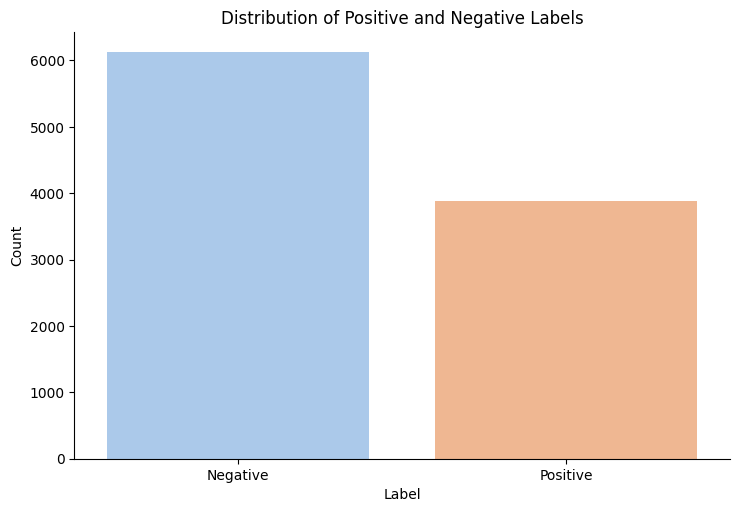

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df['label_name'] = df['label'].apply(lambda x: 'Positive' if x == 1 else 'Negative')
sns.catplot(x='label_name', kind='count', data=df, height=5, aspect=1.5, palette='pastel')
plt.title('Distribution of Positive and Negative Labels')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

In [ ]:
epochs_ = 10
seq_len = 20
batch_size_ = 64
training_size = .8
embedding_len = 100

# Basically here the total data is divided into 80% in trianing, 20% in testing and the test one is further divided into validation (50%) and testing (50%)
x_train, x_test, y_train, y_test = train_test_split(df['clean_content'], df['label'], test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

fig = px.pie(values=[len(x_train), len(x_test), len(x_val)], title='Distribution of Training,Testing and Validation Tweets' ,
             names= ['Training', 'Testing','Validation'], hover_name = ['Training', 'Testing','Validation'] , opacity = .9, template = 'simple_white')
fig.show()

In [ ]:
# Using One hot coding changing the text to a vector.
vec = CountVectorizer(binary = True)
vec = vec.fit(df['clean_content'])



enc_tweets = vec.transform(df['clean_content']).toarray()

x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['label'], test_size = training_size, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)



# Building out first neural network :)
model = Sequential()

# This is a linear stack of layers we create model by adding layers sequentially and tunning the value where it gave the best result :)
model.add(Dense(2048, activation='relu', input_shape=(enc_tweets.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

history_1 = model.fit(x_train, y_train, epochs = epochs_, batch_size = batch_size_, validation_data=(x_val, y_val))
print('\n')
print("Model Evaluation on Testing Data : ", round(model.evaluate(x_test,y_test)[1]*100,2))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 766ms/step - accuracy: 0.5792 - loss: 0.6899 - val_accuracy: 0.6273 - val_loss: 0.6805
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 713ms/step - accuracy: 0.5707 - loss: 0.6845 - val_accuracy: 0.6273 - val_loss: 0.6714
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 715ms/step - accuracy: 0.6006 - loss: 0.6730 - val_accuracy: 0.6273 - val_loss: 0.6638
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 867ms/step - accuracy: 0.6076 - loss: 0.6544 - val_accuracy: 0.6273 - val_loss: 0.6537
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 725ms/step - accuracy: 0.6204 - loss: 0.6340 - val_accuracy: 0.6320 - val_loss: 0.6364
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 690ms/step - accuracy: 0.6586 - loss: 0.5930 - val_accuracy: 0.6877 - val_loss: 0.6044
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 717ms/step - accuracy: 0.8034 - loss: 0.4978 - val_accuracy: 0.7255 - val_loss: 0.5661
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 855ms/step - accuracy: 0.9064 - loss: 0.3713 - val_accu

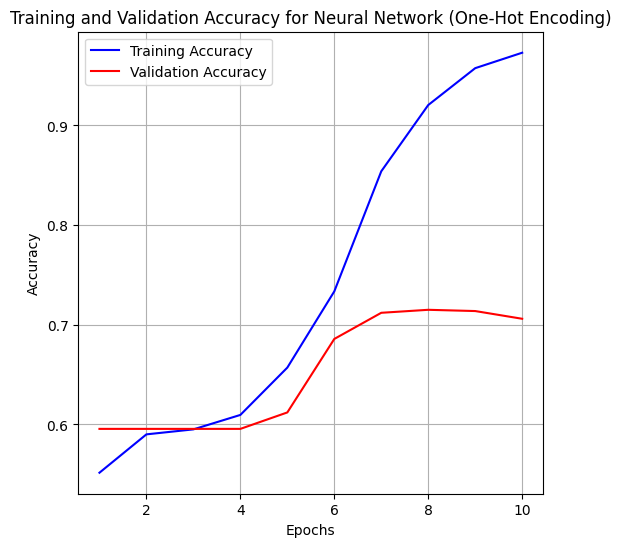

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Neural Network (One-Hot Encoding)')
plt.legend(loc='best')
plt.grid(True)

# Add text annotation
plt.show()


In [ ]:
# Using Text Encoding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_content'])

word_index = tokenizer.word_index
index_word = tokenizer.index_word

sequences = tokenizer.texts_to_sequences(df['clean_content'])
enc_tweets = pad_sequences(sequences, maxlen = seq_len, padding = 'post')

x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['label'], test_size = training_size, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(seq_len,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

history_4 = model.fit(x_train, y_train, epochs = epochs_, batch_size = batch_size_, validation_data=(x_val, y_val))
print('\n')
print("Model Evaluation on Testing Data : ", round(model.evaluate(x_test,y_test)[1]*100,2))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6121 - loss: 245.3878 - val_accuracy: 0.5995 - val_loss: 174.6717
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6008 - loss: 159.2572 - val_accuracy: 0.5970 - val_loss: 131.8957
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5850 - loss: 119.9771 - val_accuracy: 0.5930 - val_loss: 110.0150
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5831 - loss: 102.2721 - val_accuracy: 0.5893 - val_loss: 92.9962
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6047 - loss: 87.1117 - val_accuracy: 0.5790 - val_loss: 81.9163
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5940 - loss: 77.5860 - val_accuracy: 0.5867 - val_loss: 74.1111
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5836 - loss: 67.4862 - val_accuracy: 0.5767 - val_loss: 68.1999
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5737 - loss: 65.2694 - val_accura

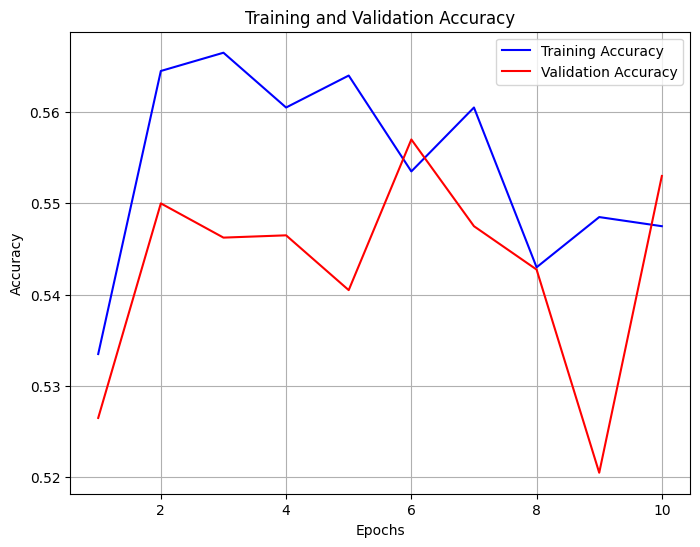

In [ ]:
# Extracting accuracy from training history
train_acc = history_4.history['accuracy']
val_acc = history_4.history['val_accuracy']
epochs_range = range(1, len(train_acc) + 1)

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# **2. FEATURE ENGINEERING**

In [ ]:
def get_word_len(content):
    return len(content.split(' '))

def get_char_len(content):
    return len(content)

def preprocess_data(content):
    content = content.lower()
    content = re.sub(r"http\S+|www\S+|https\S+", '', content, flags=re.MULTILINE)  # Remove links
    content = re.sub(r'@\w+', '', content)  # Remove mentions
    content = re.sub(r'[^a-zA-Z\s]', '', content)  # Keep only letters and spaces
    tokens = [token.lemma_ for token in nlp(content) if token not in stop_words and len(token) > 1]
    return " ".join(tokens)

# Apply preprocessing
df["clean_content"] = df["content"].apply(preprocess_data)
df["content_word_len"] = df["clean_content"].apply(get_word_len)
df["content_char_len"] = df["clean_content"].apply(get_char_len)

# Normalization of numerical values
scaler = MinMaxScaler()
numerical_cols = ["content_word_len", "content_char_len"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display processed data
df.head()

,Unnamed: 0,content,label,clean_content,content_word_len,content_char_len,label_name
8230,8230,that's a shame. It's damn good.,0,that shame its damn good,0.011905,0.015306,Negative
625,625,twinface it's ATCQ...your drunk ass can't type...,1,twinface its atcqyour drunk ass can not type lol,0.023810,0.030612,Positive
14596,14596,complete silence and all darkness.,0,complete silence and all darkness,0.020833,0.022959,Negative
14177,14177,who is the love of your life?,0,who be the love of your life,0.017857,0.017857,Negative
16478,16478,How would you handle if your partner was pres...,0,how would you handle if your partner be pressu...,0.044643,0.051658,Negative


In [ ]:
# ---------------------------
# Feature Selection on Text Data
# ---------------------------
# Convert text data into numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df["clean_content"])

# Define the target variable
y = df["label"]

# Use the Chi-Square test to select the top 1000 text features
chi2_selector = SelectKBest(chi2, k=1000)
X_text_selected = chi2_selector.fit_transform(X_text, y)
print(f"TF-IDF feature matrix shape: {X_text.shape} -> After selection: {X_text_selected.shape}")

# ---------------------------
# Combine Text Features with Numerical Features
# ---------------------------
# Convert normalized numerical features into a sparse matrix
X_numeric = df[numerical_cols].values
X_numeric_sparse = csr_matrix(X_numeric)
# Combine both feature sets horizontally
X_final = hstack([X_text_selected, X_numeric_sparse])

# ---------------------------
# Model Training
# ---------------------------
# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Train a Logistic Regression classifier
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluate model performance with a classification report
print(classification_report(y_test, y_pred))

TF-IDF feature matrix shape: (10000, 5000) -> After selection: (10000, 1000)
              precision    recall  f1-score   support

           0       0.73      0.87      0.80      1213
           1       0.72      0.50      0.59       787

    accuracy                           0.73      2000
   macro avg       0.73      0.69      0.69      2000
weighted avg       0.73      0.73      0.72      2000



# **3.MODELS**

In [ ]:
print(X_train)

[[   0    0    0 ...  115   14  932]
 [   0    0    0 ...  122 2660    7]
 [   0    0    0 ... 6060  200   19]
 ...
 [   0    0    0 ...    0    0    5]
 [   0    0    0 ...  184    6 3587]
 [   0    0    0 ... 4977  177 1060]]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical (for softmax output)
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# Convert sparse matrix to dense format
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Define and compile MLP model
mlp_model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_dense.shape[1],)),
    Dropout(0.25),
    Dense(64, activation="relu"),
    Dropout(0.25),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax")
])

mlp_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

# Train the model
history = mlp_model.fit(X_train_dense, y_train_categorical,
                        epochs=20, batch_size=64,
                        validation_data=(X_test_dense, y_test_categorical),
                        verbose=1)



Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6124 - loss: 0.6625 - val_accuracy: 0.7495 - val_loss: 0.5102
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7687 - loss: 0.4884 - val_accuracy: 0.7825 - val_loss: 0.4593
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8052 - loss: 0.4204 - val_accuracy: 0.7890 - val_loss: 0.4435
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8214 - loss: 0.3844 - val_accuracy: 0.7955 - val_loss: 0.4326
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8365 - loss: 0.3462 - val_accuracy: 0.7980 - val_loss: 0.4334
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8580 - loss: 0.3106 - val_accuracy: 0.7990 - val_loss: 0.4363
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8632 - loss: 0.2976 - val_accuracy: 0.8065 - val_loss: 0.4606
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8723 - loss: 0.2753 - val_accuracy: 0.

#**MLP**

In [ ]:
from sklearn.metrics import classification_report
y_pred_mlp = mlp_model.predict(X_test_dense).argmax(axis=1)
print("MLP Model Performance:\n", classification_report(y_test, y_pred_mlp))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
MLP Model Performance:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83      1213
           1       0.72      0.80      0.76       787

    accuracy                           0.80      2000
   macro avg       0.79      0.80      0.79      2000
weighted avg       0.81      0.80      0.80      2000



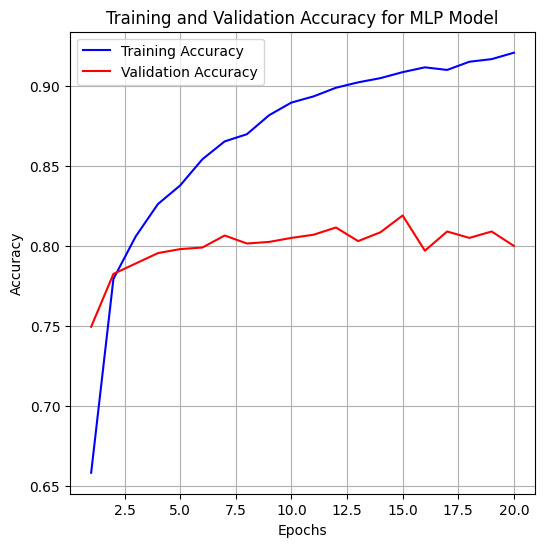

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for MLP Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()


#**ANN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build our ANN model
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}")


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6617 - loss: 0.6020 - val_accuracy: 0.7790 - val_loss: 0.4611
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8117 - loss: 0.3972 - val_accuracy: 0.7920 - val_loss: 0.4424
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8386 - loss: 0.3476 - val_accuracy: 0.7935 - val_loss: 0.4491
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8570 - loss: 0.2972 - val_accuracy: 0.8070 - val_loss: 0.4271
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8748 - loss: 0.2601 - val_accuracy: 0.7965 - val_loss: 0.4966
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8877 - loss: 0.2358 - val_accuracy: 0.8125 - val_loss: 0.4959
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8993 - loss: 0.2158 - val_accuracy: 0.8055 - val_loss: 0.5778
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9053 - loss: 0.1987 - val_accuracy: 0.

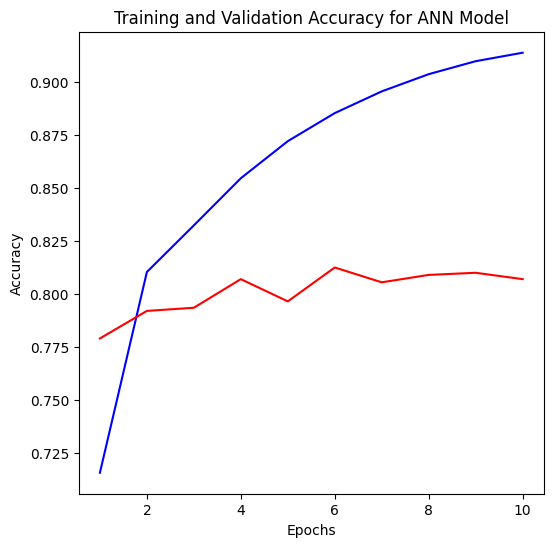

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for ANN Model')


plt.show()

# According to graph the model is overfitted if we can see its having a large difference in the 20 epoch

#**RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd


# Text vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_content"])
y = df["label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 82.75
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1213
           1       0.81      0.73      0.77       787

    accuracy                           0.83      2000
   macro avg       0.82      0.81      0.82      2000
weighted avg       0.83      0.83      0.83      2000



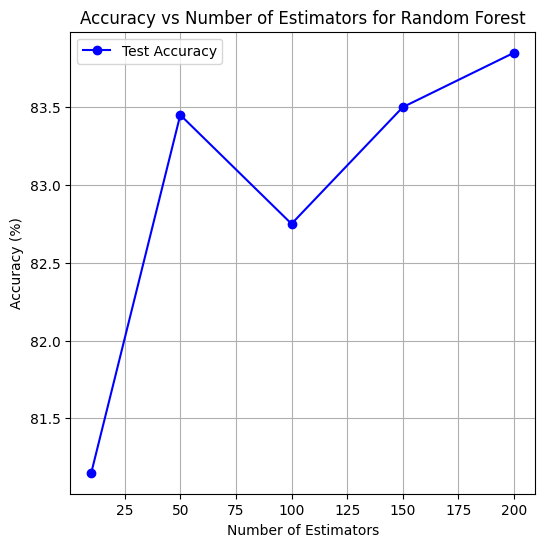

In [ ]:
import matplotlib.pyplot as plt

# for different n_estimators
# as no epoch in rf so cant take that approach to get the graph
n_estimators = [10, 50, 100, 150, 200]
accuracies = []

for n in n_estimators:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy * 100)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(n_estimators, accuracies, marker='o', linestyle='-', color='blue', label='Test Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Number of Estimators for Random Forest')
plt.legend(loc='best')
plt.grid(True)

# Add text annotation
# plt.text(n_estimators[-1] - 20, accuracies[-1] - 1, 'Graph for Random Forest', fontsize=12, color='purple')

plt.show()

#**LSTM**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_content"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["clean_content"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Labels
labels = df["label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define LSTM model
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 98ms/step - accuracy: 0.6042 - loss: 0.6755 - val_accuracy: 0.6065 - val_loss: 0.6708
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.6054 - loss: 0.6724 - val_accuracy: 0.6065 - val_loss: 0.6716
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.6064 - loss: 0.6725 - val_accuracy: 0.6065 - val_loss: 0.6716
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.6050 - loss: 0.6713 - val_accuracy: 0.6065 - val_loss: 0.6704
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.6058 - loss: 0.6718 - val_accuracy: 0.6065 - val_loss: 0.6716
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5886 - loss: 0.6775
Test Accuracy: 60.65%


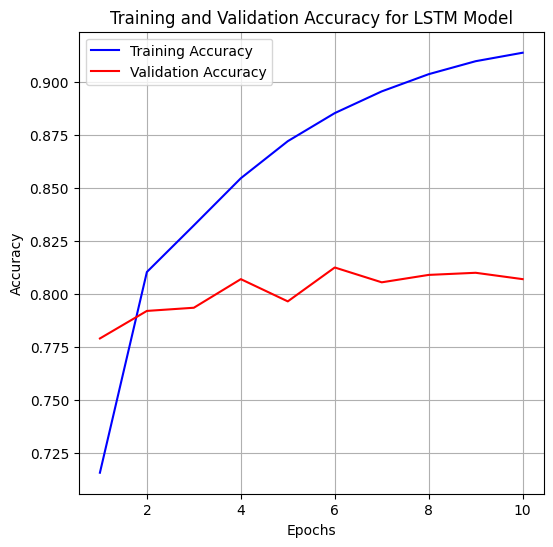

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for LSTM Model')
plt.legend(loc='best')
plt.grid(True)

# Add text annotation

plt.show()


#**GRU**

In [ ]:
'''from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split

# Parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_content"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["clean_content"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Labels
labels = df["label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define GRU model
model = Sequential([
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    #Embedding(input_dim=5000, output_dim=128, input_length=100),
    GRU(128, return_sequences=True),
    Dropout(0.5),
    GRU(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
'''

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 300ms/step - accuracy: 0.5887 - loss: 0.6778 - val_accuracy: 0.6065 - val_loss: 0.6707
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 34s 247ms/step - accuracy: 0.6101 - loss: 0.6714 - val_accuracy: 0.6065 - val_loss: 0.6703
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 206ms/step - accuracy: 0.6088 - loss: 0.6701 - val_accuracy: 0.6065 - val_loss: 0.6703
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - accuracy: 0.6070 - loss: 0.6715 - val_accuracy: 0.6065 - val_loss: 0.6721
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 198ms/step - accuracy: 0.6091 - loss: 0.6693 - val_accuracy: 0.6065 - val_loss: 0.6707
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5886 - loss: 0.6795
Test Accuracy: 60.65%


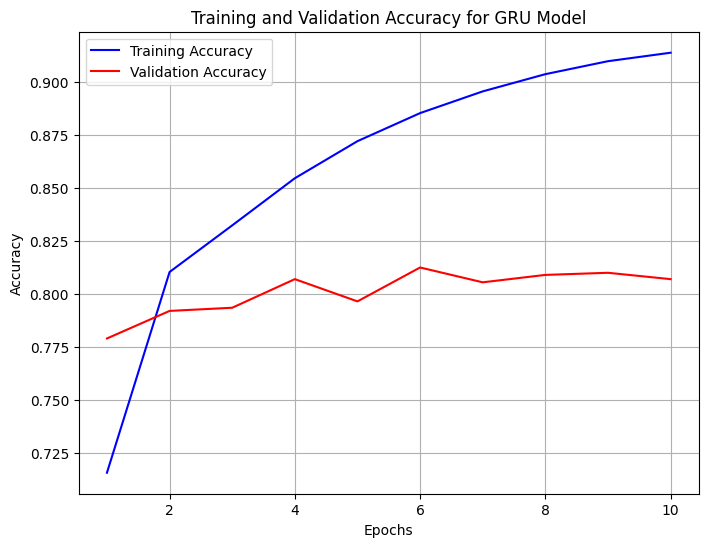

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for GRU Model')
plt.legend(loc='best')
plt.grid(True)



plt.show()


#**CONVOLUTION**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input, SpatialDropout1D
from sklearn.model_selection import train_test_split

# Parameters
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_content"])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["clean_content"])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Labels
labels = df["label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Build Convolutional model
model = Sequential([
    Input(shape=(100,)),
    Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6030 - loss: 0.6705 - val_accuracy: 0.7205 - val_loss: 0.5666
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7566 - loss: 0.5031 - val_accuracy: 0.7640 - val_loss: 0.4807
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.8781 - loss: 0.3041 - val_accuracy: 0.7795 - val_loss: 0.4894
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9448 - loss: 0.1639 - val_accuracy: 0.7990 - val_loss: 0.5558
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9707 - loss: 0.0942 - val_accuracy: 0.7930 - val_loss: 0.6334
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9824 - loss: 0.0601 - val_accuracy: 0.8125 - val_loss: 0.7569
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.9869 - loss: 0.0381 - val_accuracy: 0.7780 - val_loss: 0.8348
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9917 - loss: 0.0265 - val_a

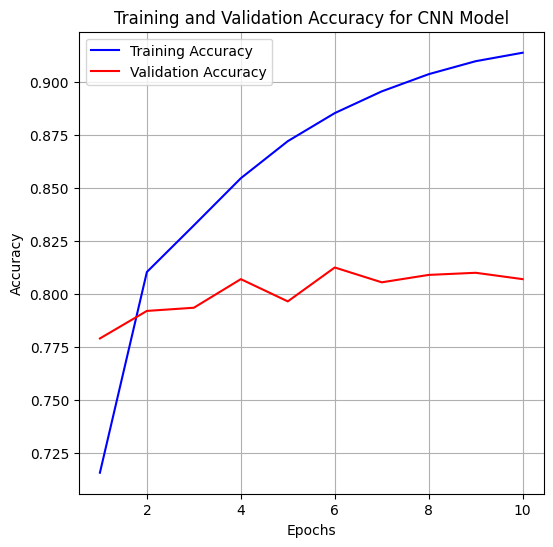

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for CNN Model')
plt.legend(loc='best')
plt.grid(True)

# Add text annotation
# plt.text(epochs[-1] / 2, 0.5, 'Graph for CNN Model', fontsize=12, color='purple')

plt.show()


#**Bidirectional + LSTM**

In [ ]:
import tensorflow as tf
import re
import nltk
import spacy
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tqdm import tqdm

# Load Spacy model and stopwords
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_data(content):
    content = content.lower()
    content = re.sub(r"http\S+|www\S+|https\S+", '', content)  # Remove links
    content = re.sub(r'@\w+', '', content)  # Remove mentions
    content = re.sub(r'[^\w\s#]', '', content)  # Remove special characters
    tokens = [token.lemma_ for token in nlp(content) if token.text not in stop_words and len(token.text) > 1]
    return " ".join(tokens)

# Apply preprocessing
df['clean_content'] = df['content'].apply(preprocess_data)

# Tokenization and padding
max_words = 10000
max_len = 100
embedding_dim = 125
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_content'])

X = tokenizer.texts_to_sequences(df['clean_content'])
X = pad_sequences(X, maxlen=max_len, padding='post', truncating='post')

y = df['label'].values

# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define Bidirectional LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
epochs = 10
batch_size = 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 201ms/step - accuracy: 0.6083 - loss: 0.6650 - val_accuracy: 0.6800 - val_loss: 0.6026
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.7859 - loss: 0.4799 - val_accuracy: 0.7563 - val_loss: 0.5150
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 200ms/step - accuracy: 0.8951 - loss: 0.2945 - val_accuracy: 0.7487 - val_loss: 0.5824
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.9177 - loss: 0.2230 - val_accuracy: 0.7531 - val_loss: 0.6824
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.9515 - loss: 0.1445 - val_accuracy: 0.7613 - val_loss: 0.7990
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.9627 - loss: 0.1074 - val_accuracy: 0.7625 - val_loss: 0.9214
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.9737 - loss: 0.0724 - val_accuracy: 0.7606 - val_loss: 1.0388
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.9708 - loss: 0

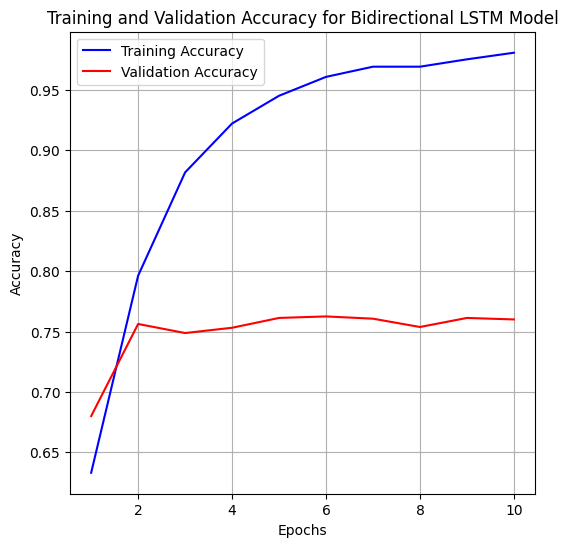

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot the accuracy
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Bidirectional LSTM Model')
plt.legend(loc='best')
plt.grid(True)

plt.show()


#**BIDIRECTIONAL + GRU**

In [ ]:
'''import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming df['clean_content'] is already preprocessed
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_content'])
X = tokenizer.texts_to_sequences(df['clean_content'])
X = pad_sequences(X, maxlen=50)

# Labels
y = df['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Architecture
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=50),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile Model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

# Predict and Calculate Accuracy
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
'''

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.6128 - loss: 0.6502 - val_accuracy: 0.7135 - val_loss: 0.5376
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.8063 - loss: 0.4268 - val_accuracy: 0.7565 - val_loss: 0.5074
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9105 - loss: 0.2296 - val_accuracy: 0.7655 - val_loss: 0.5746
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.9484 - loss: 0.1396 - val_accuracy: 0.7855 - val_loss: 0.6913
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.9668 - loss: 0.0960 - val_accuracy: 0.7670 - val_loss: 0.7304
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9750 - loss: 0.0745 - val_accuracy: 0.7920 - val_loss: 0.8178
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9792 - loss: 0.0602 - val_accuracy: 0.7845 - val_loss: 0.9230
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.9832 - loss: 0

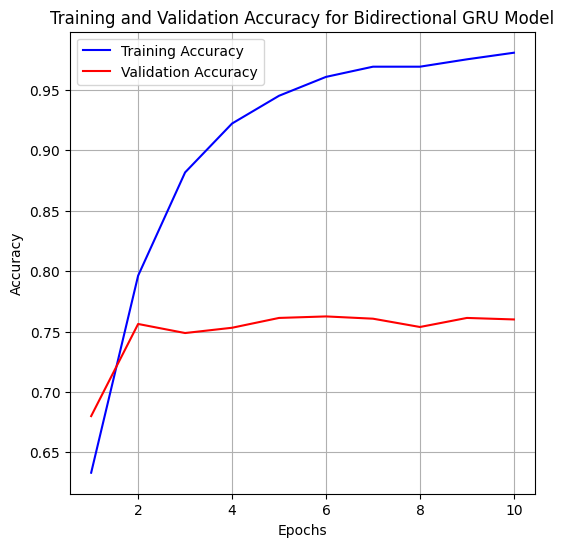

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Bidirectional GRU Model')
plt.legend(loc='best')
plt.grid(True)

# Add annotation
# plt.text(epochs[-1] / 2, 0.5, 'Graph for Bidirectional GRU Model', fontsize=12, color='purple')

plt.show()
